In [1]:
import pandas as pd

df = pd.read_csv("../../data/preprocessed_AQI_data.csv")
df.head()

,Country,AQI Category,CO AQI Value,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,PM2.5 AQI Value,PM2.5 AQI Category
0,134,2,1,36,0,0,51,2
1,23,0,1,5,0,1,41,0
2,77,2,1,39,0,2,66,2
3,126,0,1,34,0,0,20,0
4,176,2,1,14,0,11,54,2


In [2]:
from sklearn.model_selection import train_test_split

# shuffle the data before splitting
df_shuffled = df.sample(frac=1, random_state=19)
X = df_shuffled.drop(["AQI Category"], axis=1)
y = df_shuffled["AQI Category"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.8, random_state=22
)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2845, 7) (11384, 7)
(2845,) (11384,)


In [3]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svm_classifier = SVC(kernel="linear")
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy:", accuracy_svm)

SVM Accuracy: 0.9951686577652846


In [4]:
from sklearn.model_selection import GridSearchCV

import warnings

warnings.filterwarnings("ignore")

In [5]:
# COMMENTED THIS BECAUSE IT TAKES TOO LONG TO RUN
# param_grid = {
#     'C': [0.1, 1],
#     'gamma': [0.1, 1],
#     'kernel': ['rbf', 'sigmoid', 'linear']
# }

# svm_classifier = SVC()
# grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# grid_search.fit(X_train, y_train)

best params 
{'C': 0.1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.1,
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


In [6]:
# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)

Best Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Best Score: 0.9912136396443662

In [7]:
best_params = {
    "C": 0.1,
    "break_ties": False,
    "cache_size": 200,
    "class_weight": None,
    "coef0": 0.0,
    "decision_function_shape": "ovr",
    "degree": 3,
    "gamma": 0.1,
    "kernel": "linear",
    "max_iter": -1,
    "probability": False,
    "random_state": None,
    "shrinking": True,
    "tol": 0.001,
    "verbose": False,
}

In [8]:
svm_model2 = SVC(**best_params)
svm_model2.get_params()

{'C': 0.1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.1,
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [9]:
svm_model2.fit(X_train, y_train)

SVC(C=0.1, gamma=0.1, kernel='linear')

In [10]:
y_preds = svm_model2.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_preds)
print("SVM Accuracy:", accuracy_svm)

SVM Accuracy: 0.9924455375966268


In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_preds)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[5301    0    0    0    0    0]
 [   0   33    0    0    0    8]
 [   0    0 4740    0    1    0]
 [   0    0    0  593   18    7]
 [   0    0    0   28  560    0]
 [   0    0    0   23    1   71]]


In [12]:
report = classification_report(y_test, y_preds)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5301
           1       1.00      0.80      0.89        41
           2       1.00      1.00      1.00      4741
           3       0.92      0.96      0.94       618
           4       0.97      0.95      0.96       588
           5       0.83      0.75      0.78        95

    accuracy                           0.99     11384
   macro avg       0.95      0.91      0.93     11384
weighted avg       0.99      0.99      0.99     11384



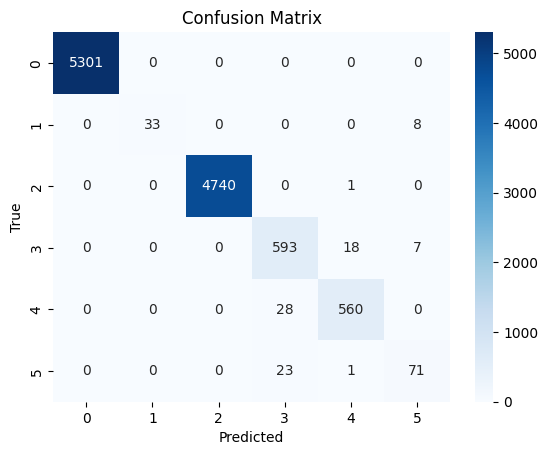

In [13]:
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="g")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    make_scorer,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
)

# here we define different scorers metrics
scorer_f1 = make_scorer(f1_score, average="weighted")
scorer_precision = make_scorer(precision_score, average="weighted", zero_division=1)
scorer_recall = make_scorer(recall_score, average="weighted")
scorer_accuracy = make_scorer(accuracy_score)

# we save them in a dict for easier accessing
scorers = {
    "f1": scorer_f1,
    "precision": scorer_precision,
    "accuracy": scorer_accuracy,
    "recall": scorer_recall,
}
scores_results: dict = {}
for scorer_name, scorer in scorers.items():
    scores = cross_val_score(svm_model2, X_train, y_train, cv=5, scoring=scorer)
    print(f"{scorer_name.capitalize()} scores:", scores)
    scores_results[scorer_name] = round(scores.mean(), 4)
    print(f"{scorer_name.capitalize()} mean:", round(scores.mean(), 4), "\n")

F1 scores: [0.99213323 0.99116999 0.99294431 0.99444863 0.99090264]
F1 mean: 0.9923 

Precision scores: [0.99307996 0.99183285 0.99366579 0.99434315 0.99086915]
Precision mean: 0.9928 

Accuracy scores: [0.99297012 0.99121265 0.99297012 0.99472759 0.99121265]
Accuracy mean: 0.9926 

Recall scores: [0.99297012 0.99121265 0.99297012 0.99472759 0.99121265]
Recall mean: 0.9926 



In [15]:
import pandas as pd

scores_df = pd.DataFrame.from_dict(scores_results, orient="index", columns=["Scores"])
scores_df

,Scores
f1,0.9923
precision,0.9928
accuracy,0.9926
recall,0.9926
